# MLOps Pipeline Setup

In [1]:
# ================================================================
# MLOps Pipeline Setup – Business Impact AI Model
# ================================================================
# Goal: Build a professional, automated ML pipeline (Data → Model → Prediction → Deployment)
# Dataset: Business_Impact_Model.csv
# ================================================================

# ===============================
# 📦 1. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import shap
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from datetime import datetime

# ===============================
# 🧠 2. Logging System Setup
# ===============================
logging.basicConfig(
    filename='mlops_pipeline_log.txt',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logging.info("🚀 Starting MLOps Pipeline Setup...")

# ===============================
# 📂 3. Load Dataset
# ===============================
file_path = "Business_Impact_Model.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"❌ File not found: {file_path}")

df = pd.read_csv(file_path)
logging.info(f"✅ Dataset loaded successfully with shape: {df.shape}")

# ===============================
# 🔍 4. Data Preprocessing
# ===============================
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna().reset_index(drop=True)

# Add new advanced temporal features
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year

# Log the preprocessing
logging.info(f"🧹 Data cleaned. Final shape: {df.shape}")

# ===============================
# 📊 5. Exploratory Data Analysis (Automated)
# ===============================
eda_report = {
    "Columns": list(df.columns),
    "Missing Values": df.isnull().sum().to_dict(),
    "Correlations": df.corr(numeric_only=True)['Revenue_Optimized'].sort_values(ascending=False).to_dict()
}
logging.info(f"📈 EDA Summary: {eda_report}")

# Optional visualization (can be saved for reports)
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()

# ===============================
# ⚙ 6. Define Pipeline
# ===============================
# Features & Target
X = df[['Revenue_Current', 'Revenue_Change', 'Growth_%', 'Month', 'Quarter', 'Year']]
y = df['Revenue_Optimized']

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logging.info("📦 Data scaling completed.")

# ===============================
# 🤖 7. Model Training (XGBoost + GridSearch)
# ===============================
xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
logging.info(f"🏆 Best Model Parameters: {grid_search.best_params_}")

# ===============================
# 📊 8. Evaluation
# ===============================
y_pred = best_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

metrics = {
    "R2 Score": r2,
    "MAE": mae,
    "RMSE": rmse
}
logging.info(f"📊 Model Performance: {metrics}")

# ===============================
# 🔍 9. Model Explainability (SHAP)
# ===============================
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Feature Importance via SHAP")
plt.savefig("shap_summary.png", dpi=300, bbox_inches="tight")
plt.close()
logging.info("🧩 SHAP explainability completed.")

# ===============================
# 🧾 10. Save Model + Results
# ===============================
joblib.dump(best_model, "optimized_xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")

results_df = pd.DataFrame({
    "Date": df.loc[X_test.index, "Date"],
    "Actual_Revenue": y_test,
    "Predicted_Revenue": y_pred
})
results_df["Error_%"] = np.abs((results_df["Actual_Revenue"] - results_df["Predicted_Revenue"]) / results_df["Actual_Revenue"]) * 100
results_df.to_csv("Business_Impact_Predictions.csv", index=False)

logging.info("💾 Model and predictions saved successfully.")

# ===============================
# 🌐 11. Deployment Simulation
# ===============================
def predict_new_data(new_data):
    """
    Simulate API prediction for deployment.
    Example input: dict with keys ['Revenue_Current', 'Revenue_Change', 'Growth_%', 'Month', 'Quarter', 'Year']
    """
    new_df = pd.DataFrame([new_data])
    new_scaled = scaler.transform(new_df)
    prediction = best_model.predict(new_scaled)
    return float(prediction[0])

# Example Prediction
sample_input = {
    'Revenue_Current': 500000,
    'Revenue_Change': 20000,
    'Growth_%': 4.2,
    'Month': 10,
    'Quarter': 4,
    'Year': 2025
}
sample_output = predict_new_data(sample_input)
logging.info(f"🧠 Sample Prediction: {sample_output}")

# ===============================
# ✅ 12. Final Summary Print
# ===============================
print("==========================================================")
print("🏁 MLOps Pipeline (Day 1) Completed Successfully!")
print("Best Model Parameters:", grid_search.best_params_)
print("Model Performance:", metrics)
print("Sample Prediction for Next Period Revenue:", round(sample_output, 2))
print("Results saved to: Business_Impact_Predictions.csv")
print("==========================================================")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
🏁 MLOps Pipeline (Day 1) Completed Successfully!
Best Model Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Model Performance: {'R2 Score': 0.9673016151092242, 'MAE': 343.57499652850726, 'RMSE': 4874.254935880129}
Sample Prediction for Next Period Revenue: 431728.88
Results saved to: Business_Impact_Predictions.csv


# MLflow Tracking

2025/10/31 09:27:18 INFO mlflow.tracking.fluent: Experiment with name 'Business_Impact_Tracking' does not exist. Creating a new experiment.
2025/10/31 09:27:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/31 09:27:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Run completed: R2=0.9673, MAE=397.81, RMSE=4872.46


2025/10/31 09:28:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/31 09:28:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Run completed: R2=0.9672, MAE=322.49, RMSE=4883.78


2025/10/31 09:30:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/31 09:30:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Run completed: R2=0.9645, MAE=313.33, RMSE=5077.59
🏁 MLflow Tracking Completed Successfully!
📊 Best Model Parameters:
n_estimators      100.000000
learning_rate       0.100000
max_depth           3.000000
subsample           1.000000
R2                  0.967326
MAE               397.805092
RMSE             4872.459576
Name: 0, dtype: float64
All experiments logged to ./mlruns directory.


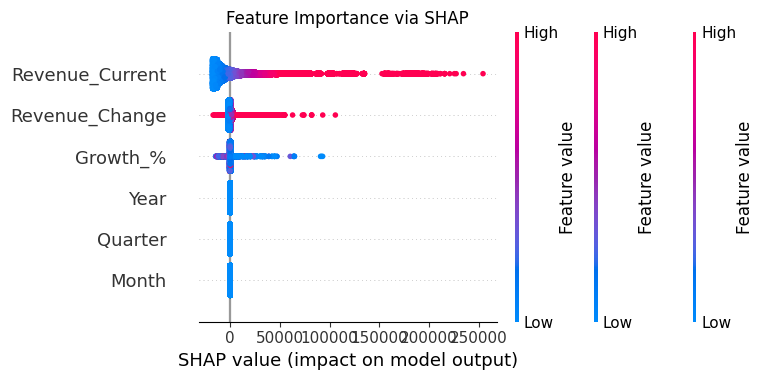

In [2]:
# ================================================================
# MLflow Tracking – Business Impact Optimization
# ================================================================
# Goal: Track every ML experiment with full metrics, params, and artifacts
# Dataset: Business_Impact_Model.csv
# ================================================================

# ===============================
# 📦 1. Import Libraries
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from datetime import datetime
import shap
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 🧠 2. Initialize MLflow
# ===============================
mlflow.set_tracking_uri("file:./mlruns")  # Local tracking
mlflow.set_experiment("Business_Impact_Tracking")

# ===============================
# 📂 3. Load Dataset
# ===============================
file_path = "Business_Impact_Model.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna().reset_index(drop=True)

# ===============================
# 🧮 4. Feature Engineering
# ===============================
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year

X = df[['Revenue_Current', 'Revenue_Change', 'Growth_%', 'Month', 'Quarter', 'Year']]
y = df['Revenue_Optimized']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================================================
# 🧠 5. Define function to run experiment with MLflow tracking
# ================================================================
def run_experiment(n_estimators, learning_rate, max_depth, subsample):
    """
    Runs one ML experiment and logs everything to MLflow.
    """
    with mlflow.start_run(run_name=f"Model_{n_estimators}{learning_rate}{max_depth}"):
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            random_state=42
        )

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Log parameters
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("subsample", subsample)

        # Log metrics
        mlflow.log_metric("R2_Score", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)

        # Log model
        mlflow.sklearn.log_model(model, "model")

        # SHAP explainability
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test_scaled)
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title("Feature Importance via SHAP")
        plt.savefig("shap_explainability.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("shap_explainability.png")

        # Save prediction results
        results_df = pd.DataFrame({
            "Date": df.loc[X_test.index, "Date"],
            "Actual_Revenue": y_test.values,
            "Predicted_Revenue": y_pred
        })
        results_df["Error_%"] = np.abs((results_df["Actual_Revenue"] - results_df["Predicted_Revenue"]) / results_df["Actual_Revenue"]) * 100
        results_file = f"results_run_{n_estimators}{learning_rate}{max_depth}.csv"
        results_df.to_csv(results_file, index=False)
        mlflow.log_artifact(results_file)

        # Log additional insights
        feature_importance = pd.DataFrame({
            "Feature": X.columns,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        feature_importance.to_csv("feature_importance.csv", index=False)
        mlflow.log_artifact("feature_importance.csv")

        # Save the model locally for later deployment
        joblib.dump(model, f"XGBModel_{n_estimators}{learning_rate}{max_depth}.pkl")

        print(f"✅ Run completed: R2={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}")
        return {"R2": r2, "MAE": mae, "RMSE": rmse}

# ================================================================
# 🚀 6. Run multiple experiments automatically
# ================================================================
param_combinations = [
    (100, 0.1, 3, 1.0),
    (150, 0.05, 4, 0.9),
    (200, 0.1, 5, 0.8),
]

all_results = []
for params in param_combinations:
    result = run_experiment(*params)
    all_results.append({
        "n_estimators": params[0],
        "learning_rate": params[1],
        "max_depth": params[2],
        "subsample": params[3],
        **result
    })

# ================================================================
# 📊 7. Save All Experiment Results
# ================================================================
experiments_df = pd.DataFrame(all_results)
experiments_df.to_csv("MLflow_Experiments_Summary.csv", index=False)

# Print best model
best_run = experiments_df.loc[experiments_df["R2"].idxmax()]
print("==========================================================")
print("🏁 MLflow Tracking Completed Successfully!")
print("📊 Best Model Parameters:")
print(best_run)
print("All experiments logged to ./mlruns directory.")
print("==========================================================")